In [95]:
from numpy.lib.shape_base import _kron_dispatcher
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplot
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from mlxtend.preprocessing import TransactionEncoder
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
import matplotlib.ticker as ticker
from langdetect import detect, detect_langs
import gower

In [96]:
cupid = pd.read_csv("C:/Users/Phoenix/Desktop/okcupid.csv")
df = cupid.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   status       59946 non-null  object 
 2   sex          59946 non-null  object 
 3   orientation  59946 non-null  object 
 4   body_type    54650 non-null  object 
 5   diet         35551 non-null  object 
 6   drinks       56961 non-null  object 
 7   drugs        45866 non-null  object 
 8   education    53318 non-null  object 
 9   ethnicity    54266 non-null  object 
 10  height       59943 non-null  float64
 11  income       59946 non-null  int64  
 12  job          51748 non-null  object 
 13  last_online  59946 non-null  object 
 14  location     59946 non-null  object 
 15  offspring    24385 non-null  object 
 16  pets         40025 non-null  object 
 17  religion     39720 non-null  object 
 18  sign         48890 non-null  object 
 19  smok

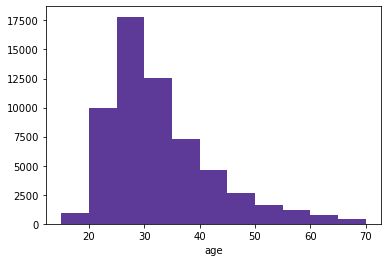

In [54]:
### ===================================age=================================== ###
df.age.isna().sum()
df.age.value_counts()

# for ages that are over 100, we will set them to the mean of ages
df.loc[(df.age == 110)|(df.age == 109), 'age'] = round(df[df.age < 100].age.mean(),0)

plt.hist(df.age, color="#5e3a98", bins=np.arange(15, 71, step=5))
plt.xlabel("age")
plt.show()

In [97]:
### ===================================status=================================== ###
# create dummies: available (1=yes, 0=no), relationship (1=in one, 0=not in one), married (1=yes, 0=no)
df['status'] = np.where(df['status'].str.contains('single'), 'available', df['status'])
df = pd.concat([pd.get_dummies(df.status, prefix='status', prefix_sep='_'), df], axis = 1)
# drop unknown since there are only a few people that fall into this category
df.drop("status_unknown", axis="columns", inplace=True)

df.status.value_counts()

available         57562
seeing someone     2064
married             310
unknown              10
Name: status, dtype: int64

In [56]:
### ===================================sex=================================== ###
# with make or female
df = pd.concat([pd.get_dummies(df.sex, prefix='sex', prefix_sep='_'), df], axis = 1)
# remove female column to reduce redundancy
df.drop("sex_f", axis="columns", inplace=True)

df.sex.value_counts()

m    35829
f    24117
Name: sex, dtype: int64

In [57]:
### ===================================orientation=================================== ###
# either straight, gay, or bisexual
df = pd.concat([pd.get_dummies(df.orientation, prefix='orientation', prefix_sep='_'), df], axis = 1)

df.drop("orientation_bisexual", axis="columns", inplace=True)

df.orientation.value_counts()

straight    51606
gay          5573
bisexual     2767
Name: orientation, dtype: int64

In [58]:
### ===================================body_type=================================== ###
df.body_type.fillna("unknown", inplace=True)

# group body types 
df['body_type'] = np.where(df['body_type'].str.contains('athletic|fit|jacked'), 'fit', df['body_type'])
df['body_type'] = np.where(df['body_type'].str.contains('thin|skinny'), 'thin', df['body_type'])
df['body_type'] = np.where(df['body_type'].str.contains('a little extra|curvy|full figured|overweight'), 'above average', df['body_type'])
df['body_type'] = np.where(df['body_type'].str.contains('rather not say|used up'), 'unknown', df['body_type'])

# generate dummies
df = pd.concat([pd.get_dummies(df.body_type, prefix='body_type', prefix_sep='_'), df], axis = 1)
df.drop("body_type_unknown", axis="columns", inplace=True)
df.body_type.value_counts()

fit              24951
average          14652
above average     8006
thin              6488
unknown           5849
Name: body_type, dtype: int64

In [109]:
### ===================================diet=================================== ###
df.diet.fillna("no restriction", inplace=True)

# create dummy variable: strict (1=strictly following a diet)
df['strict'] = 0
df.loc[df.diet.str.contains('strictly'), 'strict'] = 1
df.loc[df.diet.str.len()==1, 'strict'] = 1

# group diets
df['diet'] = np.where(df['diet'].str.contains('strictly anything|mostly other|anything|mostly anything|strictly other|other'), 'no restriction', df['diet'])
df.loc[df.diet=='no restriction', 'strict'] = 0
df['diet'] = np.where(df['diet'].str.contains('mostly vegetarian|strictly vegan|strictly vegetarian|mostly vegan|vegan|vegetarian'), 'veggie', df['diet'])
df['diet'] = np.where(df['diet'].str.contains('mostly kosher|strictly kosher|kosher'), 'kosher', df['diet'])
df['diet'] = np.where(df['diet'].str.contains('mostly halal|strictly halal|halal'), 'halal', df['diet'])

# generate dummies
df = pd.concat([pd.get_dummies(df.diet, prefix='diet', prefix_sep='_'), df], axis = 1)
df.drop("diet_no restriction", axis="columns", inplace=True)
df.diet.value_counts()

no restriction    54066
veggie             5688
kosher              115
halal                77
Name: diet, dtype: int64

In [60]:
# how many people are strictly following each diet?
df.groupby("diet")['strict'].mean().sort_values(ascending=False)

diet
halal             0.233766
veggie            0.193917
kosher            0.156522
no restriction    0.000000
Name: strict, dtype: float64

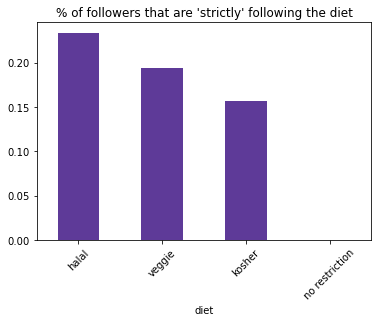

In [61]:
diet = df.groupby("diet")['strict'].mean().sort_values(ascending=False).plot(kind='bar', color="#5e3a98")
plt.xticks(np.arange(4), ['halal', 'veggie', 'kosher', 'no restriction'], rotation=45)
plt.title("% of followers that are 'strictly' following the diet")
# for p in diet.patches:
#     diet.annotate(str(round(p.get_height(), 3)), (p.get_x()*1, p.get_height()*1))
plt.show()

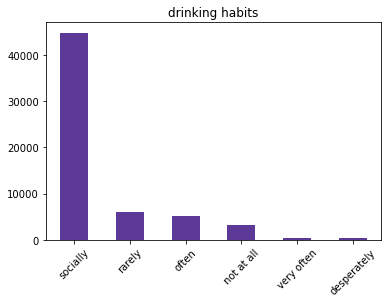

In [62]:
### ===================================drinks=================================== ###
df.drinks.fillna("socially", inplace=True)

df.drinks.value_counts().plot(kind='bar', color="#5e3a98")
plt.xticks(rotation=45)
plt.title("drinking habits")
plt.show()

df['drinks'] = np.where(df['drinks'].str.contains('not at all'), '0', df['drinks'])
df['drinks'] = np.where(df['drinks'].str.contains('rarely'), '1', df['drinks'])
df['drinks'] = np.where(df['drinks'].str.contains('socially'), '2', df['drinks'])
df['drinks'] = np.where(df['drinks'].str.contains('often'), '3', df['drinks'])
df['drinks'] = np.where(df['drinks'].str.contains('very often'), '4', df['drinks'])
df['drinks'] = np.where(df['drinks'].str.contains('desperately'), '5', df['drinks'])

df.drinks = df.drinks.astype('int64')

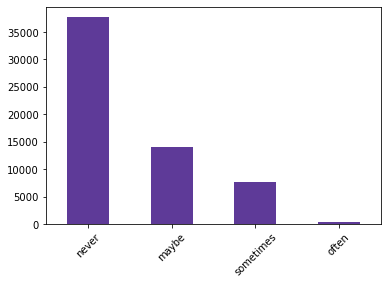

In [63]:
### ===================================drugs=================================== ###
df.drugs.fillna("maybe", inplace=True)

df.drugs.value_counts().plot(kind='bar', color="#5e3a98")
plt.xticks(rotation=45)
plt.show()

df['drugs'] = np.where(df['drugs'].str.contains('never'), '0', df['drugs'])
df['drugs'] = np.where(df['drugs'].str.contains('maybe'), '1', df['drugs'])
df['drugs'] = np.where(df['drugs'].str.contains('sometimes'), '2', df['drugs'])
df['drugs'] = np.where(df['drugs'].str.contains('often'), '3', df['drugs'])

df.drugs = df.drugs.astype('int64')

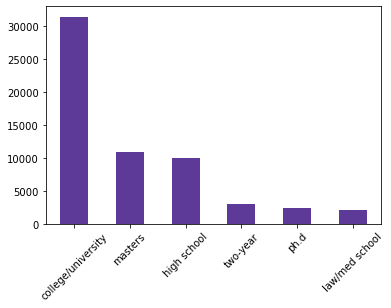

In [114]:
### ===================================education=================================== ###
df.education.fillna("0", inplace=True)

# if the person dropped out of somwhere, make it a 1, otherwise, a 0
df['dropped_out'] = np.where(df['education'].str.contains('dropped out'), 1, 0)

# if the person graduated from somwhere, make it a 1, otherwise, a 0
df['graduated'] = np.where(df['education'].str.contains('graduated'), 1, 0)

# verify
df[df.education.str.contains('dropped out')][['education', 'dropped_out', 'graduated']].head(2)

# we can use conditionals to rank the level of education by the time invested on scale from 0 - 6
df['recent_education_level'] = np.where(df['education'].str.contains('two-year'), '1', '0')
df['recent_education_level'] = np.where(df['education'].str.contains('college/university'), '2', df['recent_education_level'])
df['recent_education_level'] = np.where(df['education'].str.contains('masters program'), '3', df['recent_education_level'])
df['recent_education_level'] = np.where(df['education'].str.contains('med school') | df['education'].str.contains('law school'), '4', df['recent_education_level'])
df['recent_education_level'] = np.where(df['education'].str.contains('ph.d'), '5', df['recent_education_level'])

# verify
df[['education', 'dropped_out', 'graduated', 'recent_education_level']].head()

df.recent_education_level.value_counts().plot(kind='bar', color="#5e3a98")
plt.xticks(np.arange(6), ["college/university", "masters", "high school", "two-year", "ph.d", "law/med school"],rotation=45)
plt.show()

df.recent_education_level = df.recent_education_level.astype('int64')

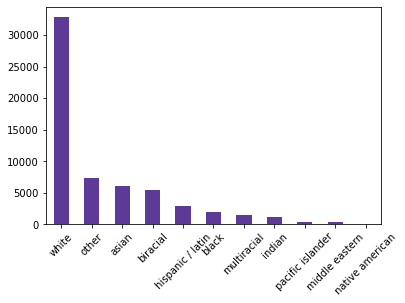

In [65]:
### ===================================ethnicity=================================== ###
df.ethnicity.fillna("other", inplace=True)
df.ethnicity = df.ethnicity.str.split(', ')

# ethnicity distribution
df['eth_num'] = df.ethnicity.str.len()
df["ethnicity2"] = "race"
df.loc[df.eth_num<2, "ethnicity2"] = df.ethnicity.str[0]
df.loc[df.eth_num==2, "ethnicity2"] = "biracial"
df.loc[df.eth_num>2, "ethnicity2"] = "multiracial"
df.loc[df.eth_num>2, "eth_num"] = 3

# plot distribution
df.ethnicity2.value_counts().plot(kind='bar', color="#5e3a98")
plt.xticks(rotation=45)
plt.show()

# how many unique races are there? --9
race = pd.DataFrame(df.explode("ethnicity").ethnicity)
# race.reset_index(inplace=True)
race.ethnicity.nunique()

df[df.ethnicity.str.len()==1].shape[0] # 53087 single race
df[df.ethnicity.str.len()==2].shape[0] # 5412 two races

# create dummy variable: 1=more than 3 races
df['mix'] = 0
df.loc[df.ethnicity.str.len()>2, 'mix'] = 1

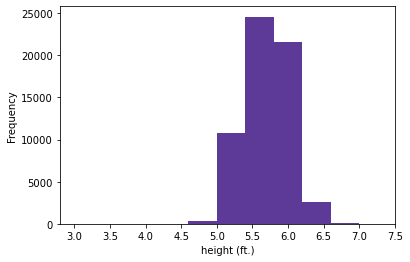

In [66]:
### ===================================height=================================== ###
mean_height = round(np.mean(df.loc[(df.height>=36) & (df.height<=84)].height), 0)
df.loc[(df.height<36)|(df.height>84)|df.height.isna(), 'height'] = int(mean_height)

df.height.plot(kind='hist', color="#5e3a98")
plt.xticks(np.arange(36, 96, step=6), [str(i) for i in np.arange(3, 8, step=0.5)])
plt.xlabel("height (ft.)")
plt.show()

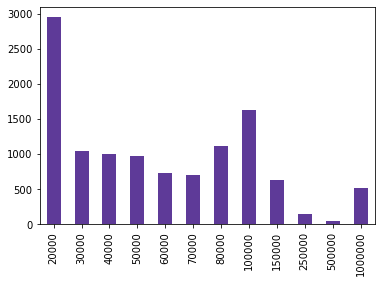

In [67]:
### ===================================income=================================== ###
#df.income.isnull().sum()
df.income.value_counts()

df.income.value_counts().iloc[1:].sort_index().plot(kind='bar', color="#5e3a98")
plt.show()

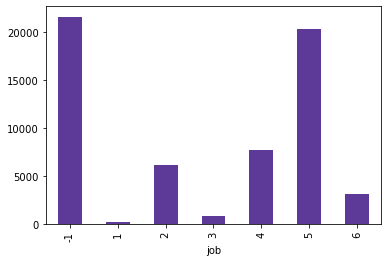

In [68]:
### ===================================job=================================== ###
# categorized by ISCO skill levels(International Standard Classification of Occupations)
       
# Unemployed or other: -1
# 1 Military: 'military'
# 2 Service and sales workers: 'sales / marketing / biz dev','transportation','hospitality / travel',
# 3 Clerical support workers:  'clerical / administrative'
# 4 Technicians and associate professionals: 'artistic / musical / writer', 'entertainment / media', 'construction / craftsmanship',
# 5 Professionals:   'computer / hardware / software', 'banking / financial / real estate','medicine / health','science / tech / engineering', 
#                 'law / legal services', 'education / academia',
# 6 Managers: 'executive / management','political / government'

df.job.isnull().sum()
df.job.fillna('rather not say',inplace=True)

df.job = np.where(df.job.str.contains('other|student|unemployed|retired|rather'), '-1', df.job)
df.job = np.where(df.job.str.contains('military'), '1', df.job)
df.job = np.where(df.job.str.contains('sales|transportation|hospitality'), '2', df.job)
df.job = np.where(df.job.str.contains('clerical'), '3', df.job)
df.job = np.where(df.job.str.contains('artistic|media|construction'), '4', df.job)
df.job = np.where(df.job.str.contains('computer|banking|medicine|science|law|education'), '5', df.job)
df.job = np.where(df.job.str.contains('executive|political'), '6', df.job)
df.job = df.job.astype(int)
df.job.nunique()

df.groupby('job').size().plot(kind='bar', color="#5e3a98")
plt.show()

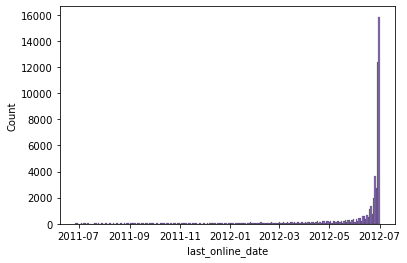

In [69]:
### ===================================last_online=================================== ###
# df.last_online.isnull().sum()
df.last_online.value_counts()

l = []
for i in df.last_online:
    j = i.split("-")
    l.append(int(j[0]+j[1]+j[2]))
df['last_online_date'] = pd.to_datetime(l,format='%Y%m%d')
sns.histplot(df,x='last_online_date',color="#5e3a98")
plt.show()

In [70]:
### ===================================location=================================== ###
west = 'Wyoming|Washington|Utah|Oregon|Alaska|Arizona|California|Colorado|Hawaii|Idaho|Montana|Nevada|New Mexico'
central = 'Wisconsin|Texas|Tennessee|South Dakota|Oklahoma|Alabama|Arkansas|Illinois|Indiana|North Dakota|Iowa|Kansas|Nebraska|Louisiana|Minnesota|Mississippi|Missouri'
northeast = 'Vermont|Pennsylvania|Rhode Island|Ohio|Connecticut|Maine|Massachusetts|Michigan|New Hampshire|New Jersey|New York'
southeast = 'West Virginia|Virginia|Delaware|Florida|Georgia|Kentucky|Maryland|North Carolina|South Carolina'
international = ''

df['region'] = 'international'

df.loc[df['location'].str.contains(west.lower()), 'region'] = "west"
df.loc[df['location'].str.contains(central.lower()), 'region'] = "central"
df.loc[df['location'].str.contains(northeast.lower()), 'region'] = "northeast"
df.loc[df['location'].str.contains(southeast.lower()), 'region'] = "southeast"

df = pd.concat([pd.get_dummies(df.region, prefix='region', prefix_sep='_'), df], axis = 1)
df.drop("region_international", axis='columns', inplace=True)

df.region.value_counts()

west             59875
northeast           32
central             19
international       11
southeast            9
Name: region, dtype: int64

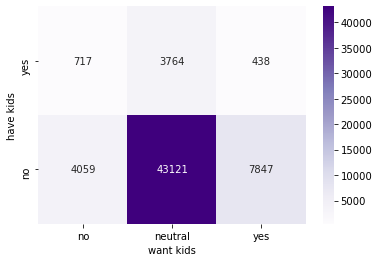

In [71]:
### ===================================offspring=================================== ###
# df.offspring.value_counts().sort_index()
df.offspring.fillna("unknown", inplace=True)

# create 2 variables: have kids (1=yes, 0=no), want kids (1=yes, 0=neutral, -1=no)
df["havekids"] = 1
df["wantkids"] = 1
df.loc[df.offspring.str.contains(r"doesn't have"), "havekids"] = 0
df.loc[df.offspring.str.contains(r"doesn't want"), "wantkids"] = -1
df.loc[(df.offspring=="doesn't want kids")|(df.offspring=="might want kids")|(df.offspring=="wants kids")|(df.offspring=="unknown"), "havekids"] = 0
df.loc[(df.offspring=="doesn't have kids")|(df.offspring=="has a kid")|(df.offspring=="has kids")|(df.offspring=="unknown"), "wantkids"] = 0
# df.groupby("offspring")[["havekids","wantkids"]].mean()

# heatmap
kids = pd.crosstab(df.havekids, df.wantkids)
kids.sort_index(ascending=False, inplace=True)
sns.heatmap(kids, cmap="Purples", annot=True, fmt='d'
            ,xticklabels=["no","neutral","yes"]
            ,yticklabels=["yes", "no"]
            )
plt.xlabel("want kids")
plt.ylabel("have kids")
plt.show()

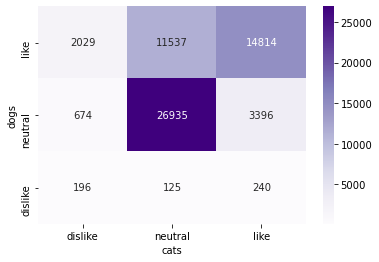

In [72]:
### ===================================pets=================================== ###
# df.pets.value_counts().sort_values()
df.pets.fillna("unknown", inplace=True)

# create 2 variables: dogs, cats (1=like, 0=neutral, -1=dislike)
df["dogs"] = 1
df["cats"] = 1
df.loc[df.pets.str.contains("dislikes dogs"), "dogs"] = -1
df.loc[df.pets.str.contains("dislikes cats"), "cats"] = -1
df.loc[df.pets.str.contains("has dogs"), "dogs"] = 0
df.loc[df.pets.str.contains("has cats"), "cats"] = 0
df.loc[(df.pets=="has dogs")|(df.pets=="likes dogs")|(df.pets=="dislikes dogs")|(df.pets=="unknown"), "cats"] = 0
df.loc[(df.pets=="has cats")|(df.pets=="likes cats")|(df.pets=="dislikes cats")|(df.pets=="unknown"), "dogs"] = 0
# df.groupby("pets")[["dogs","cats"]].mean()

# heatmap
pets = pd.crosstab(df.dogs, df.cats)
pets.sort_index(ascending=False, inplace=True)
sns.heatmap(pets, cmap="Purples", annot=True, fmt='d', 
            xticklabels=["dislike","neutral","like"],
            yticklabels=["like", "neutral", "dislike"])
plt.show()

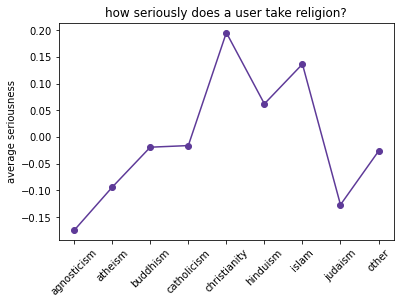

In [73]:
### ===================================religion=================================== ###
# df.religion.value_counts().sort_index()
df.religion.fillna("other", inplace=True)

# create 1 variable: serious (1=yes, 0=neutral, -1=no)
df["serious"] = 0
df.loc[df.religion.str.contains("very|somewhat"), "serious"] = 1
df.loc[df.religion.str.contains("laughing"), "serious"] = -1
df.religion = df.religion.str.split().str[0]
# df.groupby("religion")["serious"].mean()

# seriousness by religion
plt.plot(df.groupby("religion")["serious"].mean(), marker='o', color="#5e3a98")
plt.xticks(rotation=45)
plt.title("how seriously does a user take religion?")
plt.ylabel("average seriousness")
plt.show()

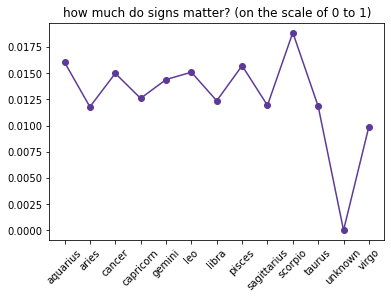

In [74]:
### ===================================sign=================================== ###
# df.sign.value_counts().sort_index()
df.sign.fillna("unknown", inplace=True)

# create 1 variable: importance (1=yes, 0=no)
df["importance"] = 0
df.loc[df.sign.str.contains("a lot"), "importance"] = 1
df.sign = df.sign.str.split().str[0]
# df.groupby("sign")["importance"].mean()

# importance by sign
plt.plot(df.groupby("sign")["importance"].mean(), marker='o', color="#5e3a98")
plt.xticks(rotation=45)
plt.title("how much do signs matter? (on the scale of 0 to 1)")
plt.show()

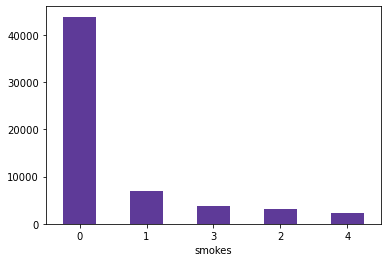

In [75]:
### ===================================smokes=================================== ###
# df.smokes.value_counts()
df.smokes.fillna("maybe", inplace=True)

# create 3 types: yes, no, unknown
# df.smokes = df.smokes.str.replace(r"^s[\w\s]*|^w[\w\s]*|^t[\w\s]*", "yes")
df.loc[df.smokes=='no', 'smokes'] = '0'
df.loc[df.smokes=='trying to quit', 'smokes'] = '1'
df.loc[df.smokes.str.contains('seems important to say'), 'smokes'] = '1'
df.loc[df.smokes=='maybe', 'smokes'] = '1'
df.loc[df.smokes=='when drinking', 'smokes'] = '2'
df.loc[df.smokes=='sometimes', 'smokes'] = '3'
df.loc[df.smokes=='yes', 'smokes'] = '4'
df.smokes = df.smokes.astype(int)

# plot
df.smokes.value_counts().plot(kind="bar", color="#5e3a98")
plt.xticks(rotation=0)
plt.xlabel("smokes")
plt.show()

In [76]:
### ===================================speaks=================================== ###
# df.speaks.value_counts().sort_index()
df.speaks.fillna("english", inplace=True)
df.speaks = df.speaks.str.split(', ')

lng = pd.DataFrame(df.explode("speaks").speaks)
lng.reset_index(inplace=True)
lng.drop(lng[lng.speaks.str.contains("poorly")].index, inplace=True)
lng.speaks = lng.speaks.str.split().str[0]

missing = sorted(set(range(df.shape[0]))-set(lng["index"]))
for i in missing:
    lng = pd.concat([lng, pd.DataFrame({"index":[i], "speaks":["english"]})])

lng = lng.groupby("index").agg({"speaks": lambda x: x.tolist()})
df.speaks = lng.speaks

# onehot dataframe of languages
encoder = TransactionEncoder().fit(df.speaks)
onehot = encoder.transform(df.speaks)
onehot = pd.DataFrame(onehot, columns = encoder.columns_)
onehot.mean().sample(10)

esperanto     0.000901
albanian      0.000183
bengali       0.000984
chechen       0.000100
chinese       0.045574
portuguese    0.011243
croatian      0.000751
russian       0.015447
sign          0.007140
english       0.996897
dtype: float64

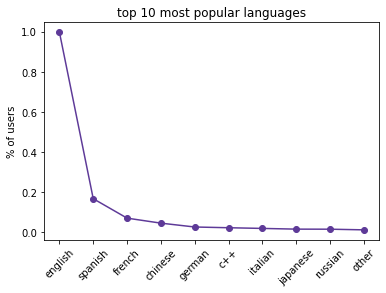

In [77]:
# 10 most popular languages
top10 = onehot.mean().sort_values(ascending=False).iloc[:10]
plt.plot(top10, marker='o', color="#5e3a98")
plt.xticks(rotation=45)
plt.ylabel("% of users")
plt.title("top 10 most popular languages")
plt.show()

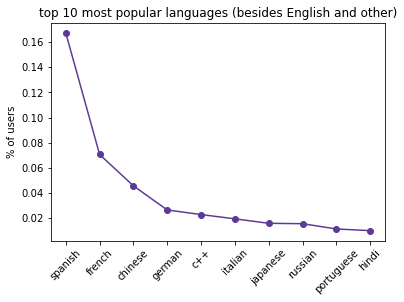

In [78]:
# 10 most popular languages besides English and other
top12 = onehot.mean().sort_values(ascending=False).iloc[1:12]
top12.drop("other", inplace=True)
plt.plot(top12, marker='o', color="#5e3a98")
plt.xticks(rotation=45)
plt.ylabel("% of users")
plt.title("top 10 most popular languages (besides English and other)")
plt.show()

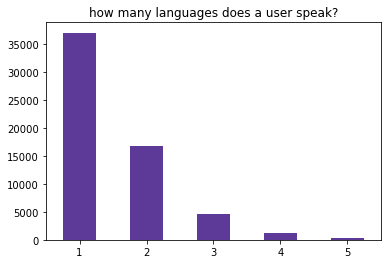

In [79]:
# create 1 variable: languages (how many does one speak)
df["languages"] = df.speaks.str.len()
# df.languages.value_counts()
df.languages.value_counts().plot(kind="bar", color="#5e3a98")
plt.xticks(rotation=0)
plt.title("how many languages does a user speak?")
plt.show()

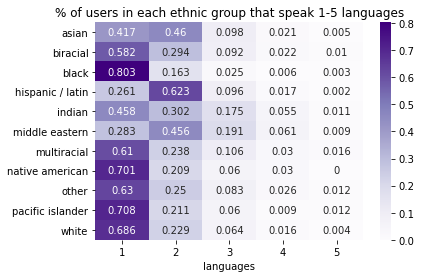

In [80]:
eth_lan = np.round(pd.crosstab(df.languages, df.ethnicity2)/pd.crosstab(df.ethnicity2, df.languages).sum(axis=1), 3).T
sns.heatmap(eth_lan, cmap='Purples', annot=True, fmt='g')
plt.title('% of users in each ethnic group that speak 1-5 languages')
plt.ylabel("")
plt.show()

In [ ]:
### ================================================================================== ###
### ===================================correlations=================================== ###
# sns.heatmap(df.corr(), cmap="Purples")
# plt.xticks(rotation=45)
# plt.show()